In [1]:
import os
import csv
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import roc_auc_score

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import ExperimentAnalysis

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1234)

In [3]:
def read_data(path):
    with open(path, 'r') as csvfile:
        train_data = list(csv.reader(csvfile))[1:] # skip col name
        sents, lbls = [], []
        for s, l in train_data:
            sents.append(s)
            lbls.append(l)
    return sents, lbls

def apply_random_masking(seq, num_tokens):
    """
    Mask `num_tokens` as 0 at random positions per sequence. 
    """
    dist = torch.rand(seq.shape)
    m, _ = torch.topk(dist, num_tokens)
    return seq * (dist < m)

def gelu(x):
    """
    Facebook Research implementation of the gelu activation function.
    
    For information: OpenAI GPT's gelu is slightly different
    (and gives slightly different results):
    0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def regularized_auc(train_auc, dev_auc, threshold=0.0025):
    """
    Returns development AUC if overfitting is below threshold, otherwise 0.
    """
    return dev_auc if (train_auc - dev_auc) < threshold else 0

In [4]:
class CleavageDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl
    
    def __getitem__(self, idx):
        return self.seq[idx], self.lbl[idx]
    
    def __len__(self):
        return len(self.lbl)
    
def collate_train(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.float)
    seq = apply_random_masking(seq, num_tokens=1)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

def collate_dev(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.float)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

In [5]:
class Attention(nn.Module):
    def __init__(self, input_dim, hidden):
        super().__init__()

        self.W0 = nn.Parameter(
            nn.init.kaiming_normal_(torch.empty(input_dim, hidden)).to(device)
        )
        self.W = nn.Parameter(
            nn.init.kaiming_normal_(torch.empty(hidden, 1)).to(device)
        )
        self.b0 = nn.Parameter(
            nn.init.kaiming_normal_(torch.empty(hidden, 1)).squeeze().to(device)
        )
        self.b = nn.Parameter(
            nn.init.kaiming_normal_(torch.empty(1, 1)).squeeze(1).to(device)
        )

    def forward(self, x):
        # input shape: (batch_size, num_filters, seq_len)
        # input needs to be permuted
        energy = (
            x.permute(0, 2, 1) @ self.W0 + self.b0
        )  # linear activation, i.e. only identity

        # input shape: (batch_size, seq_len, hidden)
        energy = (energy @ self.W + self.b).squeeze()

        # input shape: (batch_size, seq_len)
        energy = F.softmax(energy, dim=1)

        # input shape: energy=(batch_size, seq_len)
        # output shape: (batch_size, input_dim)
        # batch-wise dot product along dims 1
        res = (energy.unsqueeze(1) @ x.permute(0, 2, 1)).squeeze(1)

        # input shape: (batch_size, input_dim)
        # output shape: (batch_size, input_dim+seq_len)
        return torch.concat([res, energy], axis=-1)

In [6]:
class CNNAttention(nn.Module):
    def __init__(
        self,
        seq_len,
        num_filters1,
        kernel_size1,
        num_filters2,
        kernel_size2a,
        kernel_size2b,
        kernel_size2c,
        num_filters3,
        kernel_size3a,
        kernel_size3b,
        kernel_size3c,
        attention_hidden1,
        attention_hidden2,
        hidden_size1,
        hidden_size2,
        dropout,
    ):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=num_filters1,
            kernel_size=kernel_size1, 
            padding="same",
        )

        self.conv2a = nn.Conv1d(
            in_channels=num_filters1,  
            out_channels=num_filters2,  
            kernel_size=kernel_size2a,  
            padding="same",
        )

        self.conv2b = nn.Conv1d(
            in_channels=num_filters1,  
            out_channels=num_filters2,  
            kernel_size=kernel_size2b, 
            padding="same",
        )

        self.conv2c = nn.Conv1d(
            in_channels=num_filters1,  
            out_channels=num_filters2,  
            kernel_size=kernel_size2c, 
            padding="same",
        )

        self.conv3a = nn.Conv1d(
            in_channels=3 * num_filters2,
            out_channels=num_filters3,  
            kernel_size=kernel_size3a, 
            padding="same",
        )

        self.conv3b = nn.Conv1d(
            in_channels=3 * num_filters2,
            out_channels=num_filters3, 
            kernel_size=kernel_size3b, 
            padding="same",
        )

        self.conv3c = nn.Conv1d(
            in_channels=3 * num_filters2,
            out_channels=num_filters3,  
            kernel_size=kernel_size3c, 
            padding="same",
        )

        self.attention1 = Attention(input_dim=num_filters3, hidden=attention_hidden1)
        self.attention1r = Attention(input_dim=seq_len, hidden=attention_hidden2)

        self.attention2 = Attention(input_dim=num_filters3, hidden=attention_hidden1)
        self.attention2r = Attention(input_dim=seq_len, hidden=attention_hidden2)

        self.attention3 = Attention(input_dim=num_filters3, hidden=attention_hidden1)
        self.attention3r = Attention(input_dim=seq_len, hidden=attention_hidden2)

        self.fc1 = nn.Linear(3*num_filters3 + 3*seq_len, hidden_size1) 
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, seq):
        ### encoder ###

        # in: (batch_size, seq_len), out: (batch_size, num_filters1, seq_len)
        x1 = F.leaky_relu(self.dropout(self.conv1(seq.unsqueeze(1))))  # add dim=1 for conv

        # in: (batch_size, num_filters1, seq_len)
        # out: (batch_size, num_filters2, seq_len)
        y1 = F.leaky_relu(self.dropout(self.conv2a(x1)))
        y2 = F.leaky_relu(self.dropout(self.conv2b(x1)))
        y3 = F.leaky_relu(self.dropout(self.conv2c(x1)))
        # cat_y out: (batch_size, 3*num_filters2, seq_len)
        cat_y = self.dropout(torch.cat([y1, y2, y3], dim=1))

        # in: (batch_size, 3*num_filters2, seq_len)
        # out: (batch_size, num_filters3, seq_len)
        z1 = self.dropout(F.leaky_relu(self.conv3a(cat_y)))
        z2 = self.dropout(F.leaky_relu(self.conv3b(cat_y)))
        z3 = self.dropout(F.leaky_relu(self.conv3c(cat_y)))

        ### decoder ###

        # in: (batch_size, num_filters3, seq_len)
        # out w/out r, e.g. decoded_z1: (batch_size, num_filters3)
        # out w/ r: e.g. decoded_z1r: (batch_size, seq_len)
        decoded_z1 = self.attention1(z1)[:, : z1.shape[1]]
        decoded_z1r = self.attention1r(z1.permute(0, 2, 1))[:, : z1.shape[2]]

        decoded_z2 = self.attention2(z2)[:, : z2.shape[1]]
        decoded_z2r = self.attention2r(z2.permute(0, 2, 1))[:, : z2.shape[2]]

        decoded_z3 = self.attention3(z3)[:, : z3.shape[1]]
        decoded_z3r = self.attention3r(z3.permute(0, 2, 1))[:, : z3.shape[2]]

        # out: (batch_size, 3*num_filters3 + 3*seq_len)
        cat = self.dropout(
            torch.cat(
                [
                    decoded_z1,
                    decoded_z1r,
                    decoded_z2,
                    decoded_z2r,
                    decoded_z3,
                    decoded_z3r,
                ],
                dim=-1,
            )
        )

        # in: (batch_size, 3*num_filters3 + 3*seq_len), out: (batch_size, hidden_size1)
        out = self.dropout(F.leaky_relu(self.fc1(cat)))
        # in: (batch_size, hidden_size1), out: (batch_size, hidden_size2)
        out = self.dropout(F.leaky_relu(self.fc2(out)))
        # in: (batch_size, hidden_size2), out: (batch_size)
        return self.fc3(out).squeeze()

In [7]:
def process(model, loader, criterion, optim=None):
    epoch_loss, num_correct, total = 0, 0, 0
    preds, lbls = [], []
    
    for seq, lbl in loader:
        seq, lbl = seq.to(device), lbl.to(device)
        
        scores = model(seq)
        loss = criterion(scores, lbl)
        
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        epoch_loss += loss.item()
        num_correct += ((scores > 0) == lbl).sum().item()
        total += seq.shape[0]
        preds.extend(scores.detach().tolist())
        lbls.extend(lbl.detach().tolist())
    return epoch_loss / total, num_correct / total, roc_auc_score(lbls, preds)

In [8]:
# load train and dev data
train_seqs, train_lbl = read_data('../../data/n_train.csv')
dev_seqs, dev_lbl = read_data('../../data/n_val.csv')

# create vocab from train seqs
vocab = build_vocab_from_iterator(train_seqs, specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])
encode_text = lambda x: vocab(list(x))

In [9]:
NUM_EPOCHS = 70
VOCAB_SIZE = len(vocab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def train(config, checkpoint_dir=None):
    
    # create train and dev loader
    train_data = CleavageDataset(train_seqs, train_lbl)
    train_loader = DataLoader(train_data, batch_size=512, shuffle=True, collate_fn=collate_train, num_workers=8)

    dev_data = CleavageDataset(dev_seqs, dev_lbl)
    dev_loader = DataLoader(dev_data, batch_size=512, shuffle=True, collate_fn=collate_dev, num_workers=8)
    
    
    model = CNNAttention(
        seq_len = 10,
        num_filters1=config['num_filters1'],
        kernel_size1=1,
        num_filters2=config['num_filters2'],
        kernel_size2a=config['kernel_size2a'],
        kernel_size2b=config['kernel_size2b'],
        kernel_size2c=config['kernel_size2c'],
        num_filters3=config['num_filters3'],
        kernel_size3a=config['kernel_size3a'],
        kernel_size3b=config['kernel_size3b'],
        kernel_size3c=config['kernel_size3c'],
        attention_hidden1=config['attention_hidden1'],
        attention_hidden2=config['attention_hidden2'],
        hidden_size1=config['hidden_size1'],
        hidden_size2=config['hidden_size2'],
        dropout=config['dropout'],
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCEWithLogitsLoss()
    
    # normal train loop
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss, train_acc, train_auc = process(model, train_loader, criterion, optimizer)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_acc, val_auc = process(model, dev_loader, criterion)
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")
            torch.save(model.state_dict(), checkpoint_path)
            
        # metrics that will be reported back to main process
        reg_auc = regularized_auc(train_auc, val_auc)
        
        tune.report(
            train_loss=train_loss,
            dev_loss=val_loss,
            train_acc=train_acc,
            dev_acc=val_acc,
            train_auc=train_auc,
            dev_auc=val_auc,
            reg_auc=reg_auc,
        )
        
        # if model is overfitting, stop the run
        if reg_auc == 0:
            break

In [10]:
class TuneReporter(CLIReporter):
    def __init__(self):
        super().__init__()
        self.num_terminated = 0

    def should_report(self, trials, done=False):
        """Reports only on trial termination events."""
        old_num_terminated = self.num_terminated
        self.num_terminated = len([t for t in trials if t.status == "TERMINATED"])
        return self.num_terminated > old_num_terminated
    
    def report(self, trials, done, *sys_info):
        print(self._progress_str(trials, done, *sys_info))
    
reporter = TuneReporter()
reporter.add_metric_column(metric='train_loss')
reporter.add_metric_column(metric='dev_loss')
reporter.add_metric_column(metric='train_acc')
reporter.add_metric_column(metric='dev_acc')
reporter.add_metric_column(metric='train_auc')
reporter.add_metric_column(metric='dev_auc')
reporter.add_metric_column(metric='reg_auc')

In [11]:
search_space = {
    'num_filters1': tune.randint(220, 301),
    'num_filters2': tune.randint(220, 301),
    'kernel_size2a': tune.choice(list(range(1, 8, 2))),
    'kernel_size2b': tune.choice(list(range(15, 26, 2))),
    'kernel_size2c': tune.choice(list(range(13, 24, 2))),
    'num_filters3': tune.randint(350, 431),
    'kernel_size3a': tune.choice(list(range(11, 20, 2))),
    'kernel_size3b': tune.choice(list(range(13, 24, 2))),
    'kernel_size3c': tune.choice(list(range(11, 20, 2))),
    'attention_hidden1': tune.randint(1, 6),
    'attention_hidden2': tune.randint(1, 6),
    'hidden_size1': tune.randint(64, 101),
    'hidden_size2': tune.randint(15, 33),
    'dropout': tune.quniform(0., 0.1, 0.02),
    'lr': tune.choice([8e-5, 1e-4, 3e-4, 5e-4]),
}

In [ ]:
path = '../../params/n_term/cnnAttention2/'
experiment = 'search'
num_samples = 30

analysis = tune.run(
    train,
    name=experiment,
    config=search_space,
    sync_config=tune.SyncConfig(syncer=None),
    num_samples=num_samples,
    scheduler=ASHAScheduler(
        metric='reg_auc',
        mode='max',
        max_t=60,
        reduction_factor=2,
        grace_period=4
    ),
    progress_reporter=reporter,
    local_dir=path,
    keep_checkpoints_num=None, # keep all checkpoints
    checkpoint_score_attr='reg_auc',
    resume='AUTO',
    resources_per_trial={'cpu': 16, 'gpu': 1},
)

In [13]:
ana = ExperimentAnalysis(path + experiment)

2022-09-14 06:27:48,303	INFO experiment_analysis.py:757 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [14]:
df = ana.dataframe()
cols_needed = [col for col in df.columns if col.startswith('config/')]

In [15]:
df[['train_auc', 'dev_auc', 'reg_auc', 'training_iteration', *cols_needed]].sort_values(by='reg_auc', ascending=False)

,train_auc,dev_auc,reg_auc,training_iteration,config/attention_hidden1,config/attention_hidden2,config/dropout,config/hidden_size1,config/hidden_size2,config/kernel_size2a,config/kernel_size2b,config/kernel_size2c,config/kernel_size3a,config/kernel_size3b,config/kernel_size3c,config/lr,config/num_filters1,config/num_filters2,config/num_filters3
13,0.748815,0.768081,0.768081,60,4,3,0.08,89,15,1,15,13,13,21,15,0.00030,249,229,400
20,0.761390,0.764885,0.764885,60,1,5,0.00,81,23,3,25,15,19,15,17,0.00050,287,223,424
5,0.702634,0.725052,0.725052,16,3,1,0.04,65,29,1,21,17,15,15,17,0.00008,239,263,370
12,0.698302,0.719485,0.719485,16,3,4,0.04,84,32,3,21,13,11,19,15,0.00008,278,255,352
0,0.702224,0.715098,0.715098,16,5,1,0.04,72,29,3,23,19,19,23,17,0.00008,269,291,396
22,0.671223,0.700427,0.700427,8,4,4,0.04,68,20,7,17,13,15,17,19,0.00008,297,266,417
2,0.681270,0.696147,0.696147,8,1,4,0.04,83,24,3,21,21,11,23,13,0.00008,300,228,366
25,0.673412,0.695771,0.695771,8,2,1,0.02,66,18,5,25,15,15,15,13,0.00008,299,276,400
18,0.668674,0.689871,0.689871,8,2,3,0.06,65,29,7,23,15,11,23,19,0.00008,253,241,402
29,0.664294,0.688689,0.688689,8,3,1,0.06,80,31,5,17,19,13,17,17,0.00010,296,272,407


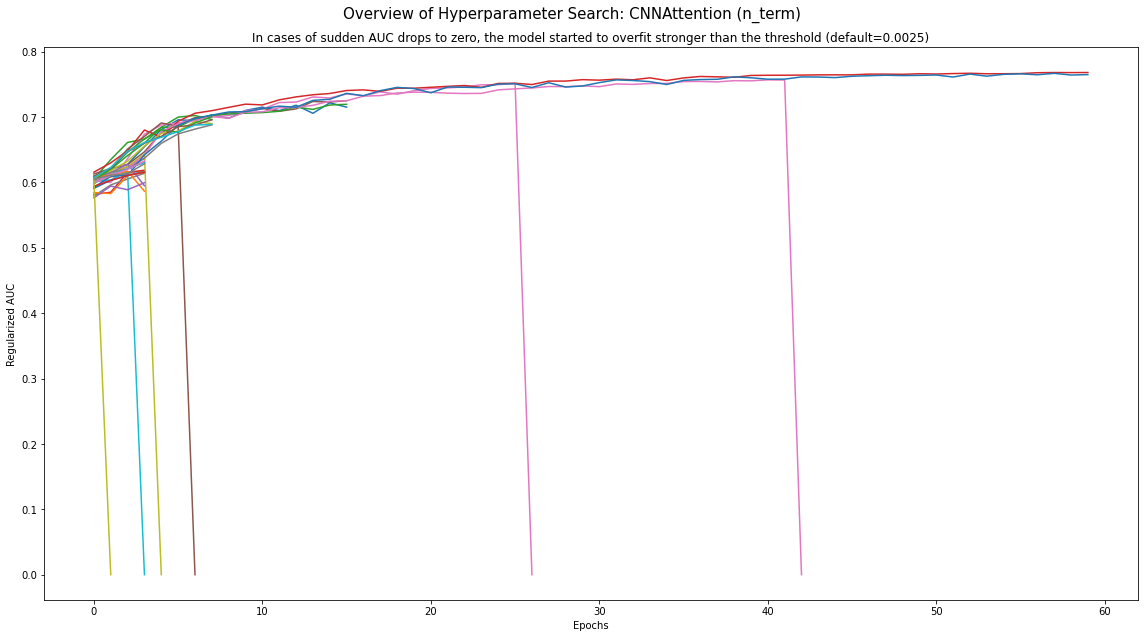

In [16]:
### when the acc suddenly drops to zero, that's when the model started to overfit stronger than the threshold (default=0.0025) 
plt.figure(figsize=(16, 9))
ax = None
for val in ana.trial_dataframes.values():
    ax = val.reg_auc.plot(ax=ax, legend=False)
plt.xlabel('Epochs')
plt.ylabel('Regularized AUC')
plt.suptitle('Overview of Hyperparameter Search: CNNAttention (n_term)', fontsize=15, ha='center')
plt.title("In cases of sudden AUC drops to zero, the model started to overfit stronger than the threshold (default=0.0025)", fontsize=12, ha='center')
plt.tight_layout()
plt.show()